<a id="there_you_go_1"></a>
# 1) Exploring the Dataset
The dataset we are going to use is the MovieLens Dataset, which cotains 100k ratings of approximately 9000 movies by 700 users.
Let's have a look at the dataset.

In [2]:
import surprise

<a id="there_you_go_1.1"></a>
## 1.1) Importing the Libraries 

In [3]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score



# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [4]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

<a id="there_you_go_1.2"></a>
## 1.2) Extract Dataset

In [5]:
ratings = pd.read_csv("C:/Users/Danish Khan/Desktop/Faltu/GitHub/Recommender-Systems-with-Collaborative-Filtering-and-Deep-Learning-Techniques-master/ratings.csv")
movies = pd.read_csv("C:/Users/Danish Khan/Desktop/Faltu/GitHub/Recommender-Systems-with-Collaborative-Filtering-and-Deep-Learning-Techniques-master/movies.csv")
df_r = ratings.copy()
df_m = movies.copy()

<a id="there_you_go_1.2.1"></a>
### 1.2.1) Ratings

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


As you can see the "ratings" dataframe has 4 columns.
* **userId** - Every user is represented by an unique Id.
* **movieId** - Every movie is represented by an uniue Id.
* **rating** - Represents the rating given by the user to the corresponding movie.
* **timestamp** - The time at which the rating was recorded.

In [7]:
ratings.shape

(100836, 4)

In [8]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Some insights that can be drawn are:

1. The minimum rating given to the movie is 0,5 whereas the maximum rating given to the movies is 5.0
2. The average rating that is the mean ratings given by the users to all the movies is 3.5
3. The users have userId's in the range 1 - 610
4. The movies have movieId's in the range 1 - 193609.( Note that 193609 is the highest movieId and not total number of movies. )

Here, we will be dropping the timestamp attribute as we are not concerned with when the user rated a particular movie.

In [9]:
ratings.drop(['timestamp'], axis=1, inplace=True)

In [10]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


<a id="there_you_go_1.2.2"></a>
### 1.2.2) Movies

In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


As you can see the "movies" dataframe has 3 columns:
* **movieId** - Every movie is represented by an unique Id.
* **title** - Movie which is represented by the corresponding movieId.
* **genres** - Represents category of the movie.

In [12]:
print('Shape: ', movies.shape, '\n')
movies.info()

Shape:  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


<a id="there_you_go_1.3"></a>
## 1.3) Combining the Movies and Ratings DataFrame
Let's have a combined view on both the ratings and movies dataframe.

And for that we need to merge on "movieId" attribute since it is common between both the dataframes.

In [13]:
df_combined = pd.merge(ratings, movies, on = 'movieId')

In [14]:
df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [15]:
df_combined.shape

(100836, 5)

<a id="there_you_go_2"></a>
# 2) Visualizations on the Dataset

<a id="there_you_go_2.1"></a>
## 2.1) Genres
Lets have a look at various genres in the Dataset.

In [16]:
# Create a function to find genres in the dataset

genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()

In [17]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [18]:
# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

<a id="there_you_go_2.1.1"></a>
### 2.1.1) Genre WordCloud

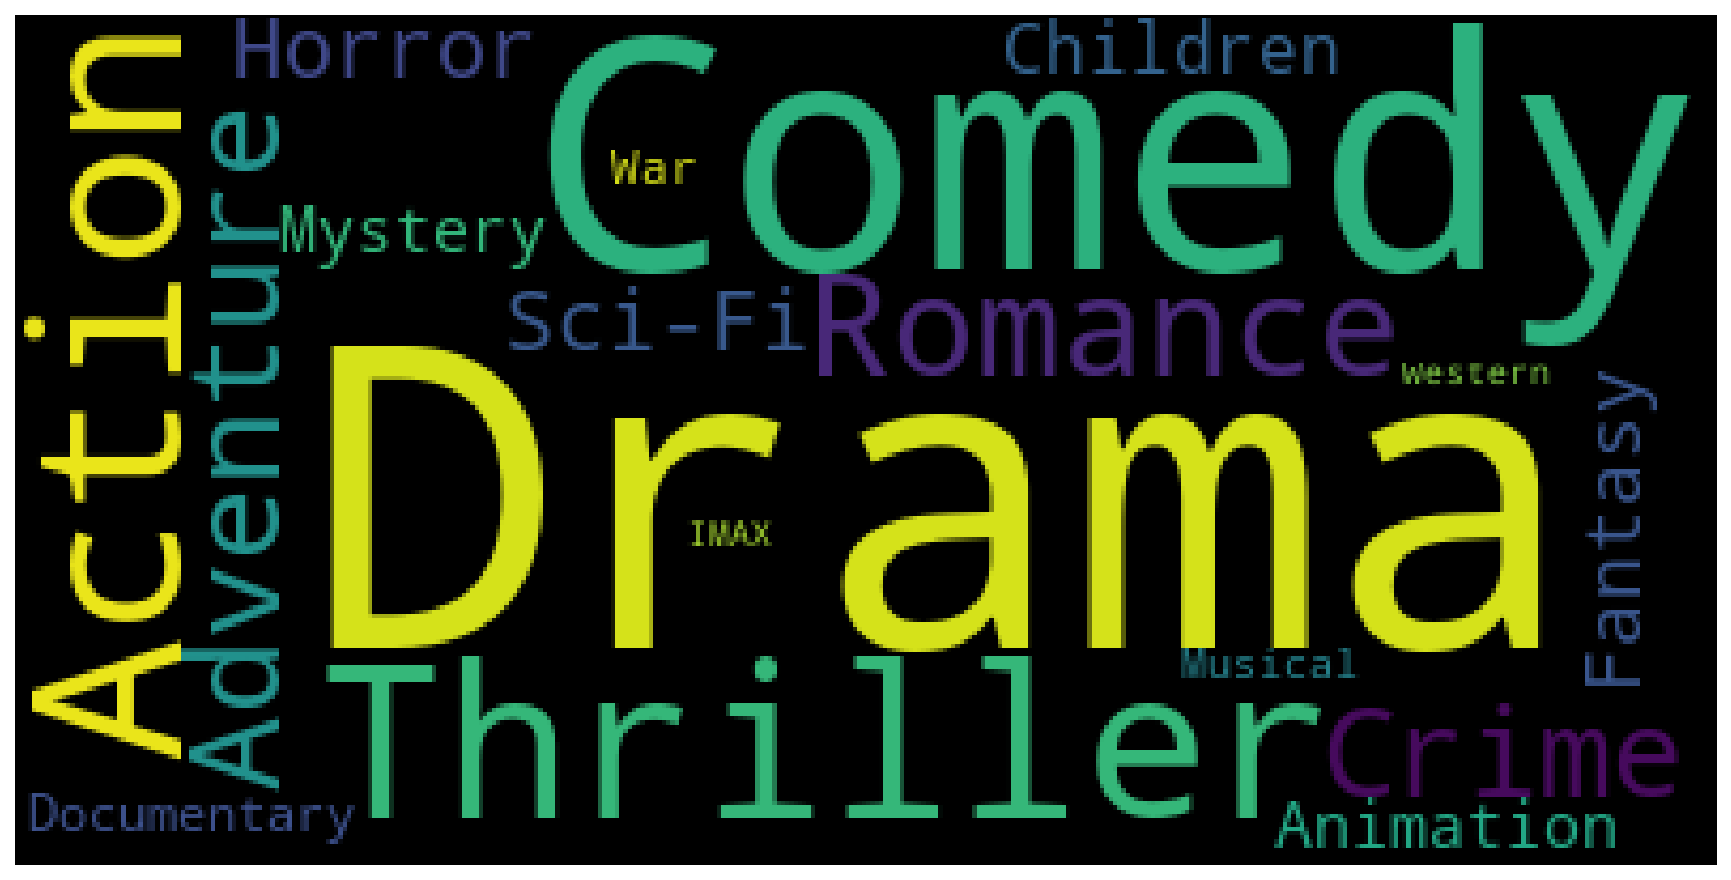

In [19]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=400, height=200, background_color = 'black', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<a id="there_you_go_2.2"></a>
## 2.2) Heavily Rated Movies

In [20]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Most of these movies stand among the Top 50 movies in the IMDB ratings even today.

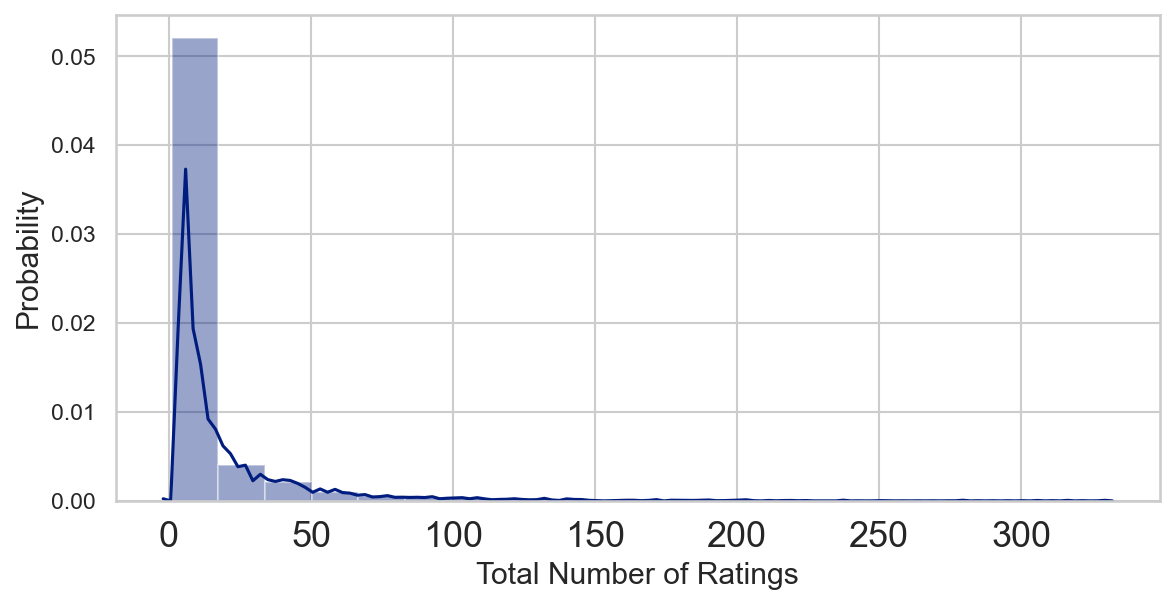

In [21]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

We can see that - 
* Majority of the movies have less than 50 ratings.
* The number of movies having more than 100 ratings is very low.

Refer one cell above, we can see that there are only 3 movies with 300+ ratings.

<a id="there_you_go_2.3"></a>
## 2.3) Highly Rated Movies

In [22]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


In [23]:
print('Total no of users that gave rating of 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of Individual users that gave rating of 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Total no of users that gave rating of 5.0 :  296 

Total no of Individual users that gave rating of 5.0 :  289


1. As you can see there are over 296 users that have rated 5 stars, among which there are 289 individual raters ( only user to rate the movie 5 star ).

2. So, this cannot be the lone factor that should be considered while recommending movies. As this factor only shows the preferences of a particular user.

3. It would make a good recommendation system if we can use both the factors ( -> Highly Rated Movies and Heavily Rated Movies <- ) together.

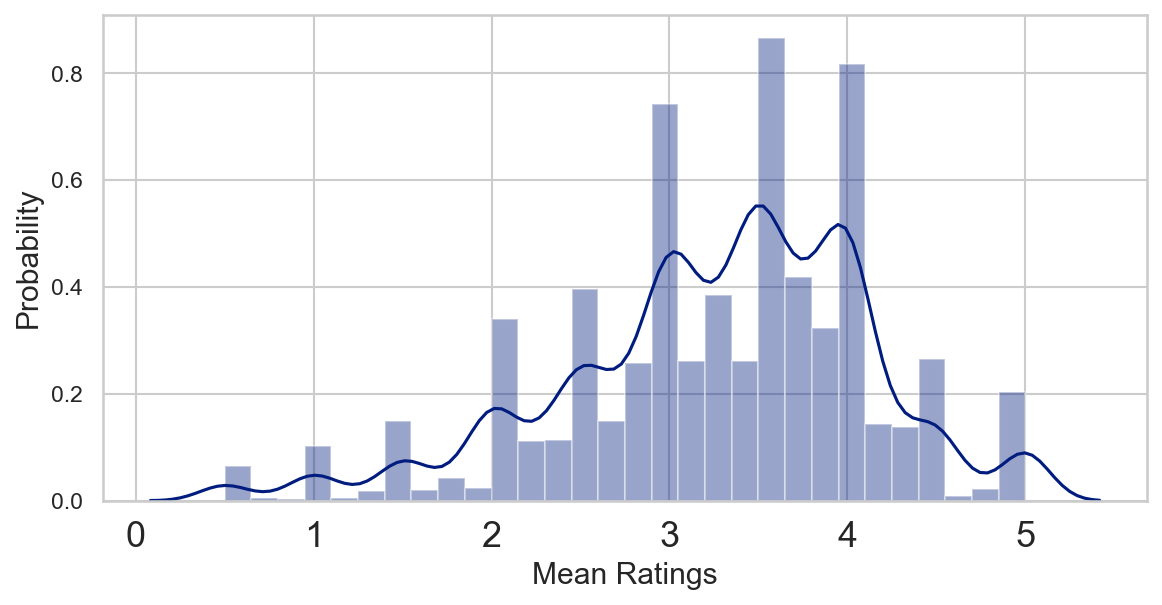

In [24]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

<a id="there_you_go_2.4"></a>
## 2.4) Mean Ratings vs Total Number of Ratings

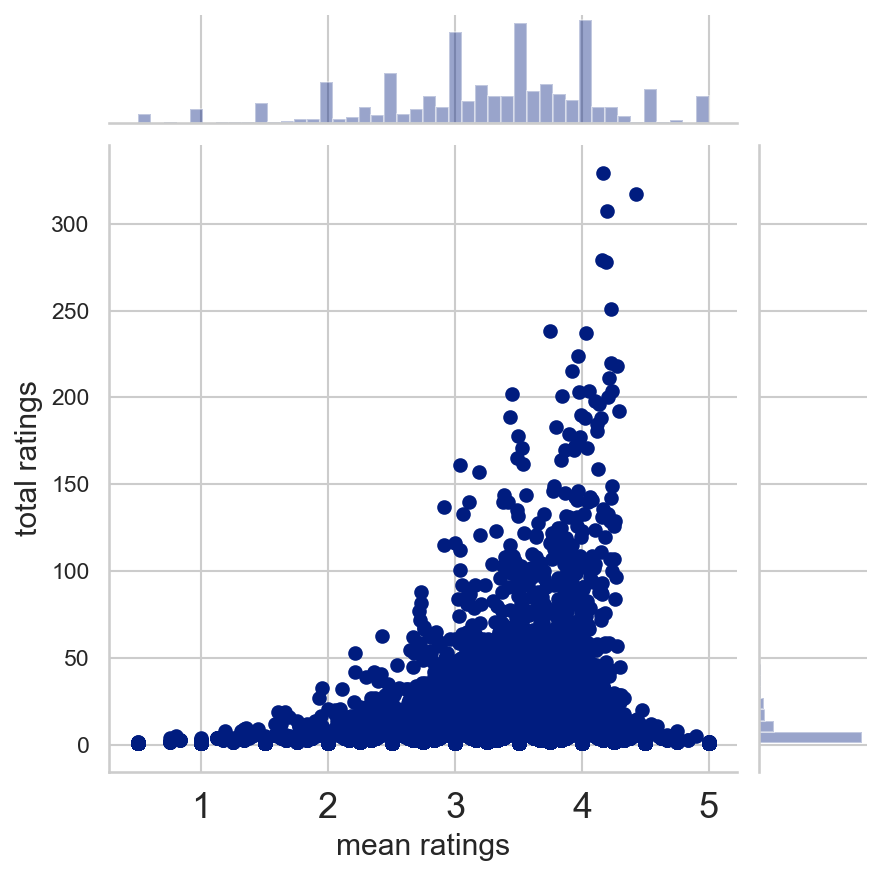

In [25]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

* Here, as you can see every Data Point represents a distinct Movie, with y-coordinate representing the total no of users which has rated that movie and x-coordinate representing the mean of all the ratings of the corresponding users.
* Also you can see that there is a huge Density in the region corresponding to 0-50 no of users and between mean rating 3-4 .

Many more Visualizations can be drawn and many different conclusions can be inferred, But here, I'm going to focus on Collaborative Filtering.

So, let's proceed to what is Collaborative Filtering and how it is used in Recommendation Systems?

<a id="there_you_go_3"></a>
# 3) Collaborative Filtering (CF)

**Collaborative filtering** is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources.Basically, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users. 

There are 2 approaches to CF -->

1) **Memory-Based CF** - It is an approach which finds similarity between users or between items to recommend similar items. Examples include Neighbourhood-based CF and Item-based/User-based top-N recommendations.

2) **Model-Based CF** - In this approach we use different data mining, machine learning algorithms to predict users' rating of unrated items.  Examples include Singular Value Decomposition (SVD) , Principal Component Analysis (PCA) etc.

<a id="there_you_go_3.1"></a>
## 3.1) Create User-Item Matrix

In [26]:
util_mat = df_combined.pivot_table(index = 'userId', columns = 'title', values = 'rating')
util_mat.head(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


<a id="there_you_go_3.2"></a>
## 3.2) Memory Based Collaborative Filtering

There are 2 approaches to Memory-Based CF -->

1) **User-User Collaborative Filtering** - In this we we calculate similarity of all the users to the active user ( the user whom the prediction is for ).Then sort and filter the Top-N users to make predictions for the active user. This is usually very effective but takes a lot of time and resources. For example if Dennis and Davis like the same movies and a new movie comes out that Davis likes,then we can recommend that movie to Dennis because Davis and Dennis seem to like the same movies.

2) **Item-Item Collaborative Filtering** - This is similar to User-User CF, just that we now compute similarity between items to recommend similar items. Eg. When you buy any product on Amazon, you will find this line "Users who bought this item also bought...", so Amazon uses item-item CF widely, Mind that I'm not saying they use only item-item CF, they have hybrid techniques to better suit users of even unique interests.

Item-Item CF are a lot faster than User-User CF. and secondly user profiles changes quickly and the entire system model has to be recomputed, whereas item's average ratings doesn't change that quickly, and this leads to more stable rating distributions in the model, so the model doesn't have to be rebuilt as often.

**Q) How do we calculate similarity?**

**Ans.** There are many measures to calculate the similarity matrix, some of them are -->

1) **Jaccard Similarity** - It is a statistic used for comparing the similarity and diversity of sample sets. It is defined as the size of the intersection divided by the size of the union of the sample sets.

2) **Cosine Similarity** - It measures the angle between the ratings vector. If the angle is 0°, then they are vectors having same orientation and if the angle is 180°, then they are highly dissimilar vectors.

3) **Pearson Similarity** - It is actually Centered-Cosine similarity. We subtract the mean ratings from the user ratings, so that the mean is centered at 0, and then calculate the cosine similarity.

<a id="there_you_go_3.2.1"></a>
### 3.2.1) User based Collaborative Filtering

In [27]:
user_util_matrix = util_mat.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [28]:
user_util_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264516e-03,5.525772e-04,0.048419,0.021847,-0.045497,-6.199672e-03,0.047013,1.950985e-02,-8.754088e-03,...,0.018127,-0.017172,-0.015221,-3.705875e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-8.476071e-25,-0.017164,0.021796,-0.021051,-1.111357e-02,-0.048085,-5.534891e-23,3.011629e-03,...,-0.050551,-0.031581,-0.001688,-3.345291e-23,-3.088913e-23,0.006226,-0.020504,-0.006001,-6.009100e-02,0.024999
3,0.000553,-8.476071e-25,1.000000e+00,-0.011260,-0.031539,0.004800,3.308497e-25,-0.032471,5.123183e-25,2.203980e-25,...,-0.004904,-0.016117,0.017749,3.085290e-25,-1.430628e-03,-0.037289,-0.007789,-0.013001,7.905178e-25,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-0.029620,0.013956,5.809139e-02,0.002065,-5.873603e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179571e-02,-3.153892e-02,-0.029620,1.000000,0.009111,1.011715e-02,-0.012284,-1.950809e-24,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627206e-02,0.026319,0.031896,-0.001751,9.382892e-02,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,6.225827e-03,-3.728895e-02,0.020590,0.026319,-0.009137,2.832591e-02,0.022277,3.163273e-02,-3.994577e-02,...,0.053683,0.016384,0.098011,6.107833e-02,1.967830e-02,1.000000,0.017927,0.056676,3.842210e-02,0.075464
607,0.055261,-2.050374e-02,-7.789105e-03,0.014628,0.031896,0.045501,3.098070e-02,0.048822,-1.216061e-02,-1.765576e-02,...,0.049059,0.038197,0.049317,2.355180e-03,-2.938114e-02,0.017927,1.000000,0.044514,1.904919e-02,0.021860
608,0.075224,-6.000828e-03,-1.300064e-02,-0.037569,-0.001751,0.021727,2.841409e-02,0.071759,3.278284e-02,-5.199963e-02,...,0.069198,0.051388,0.012801,6.318649e-03,-7.977761e-03,0.056676,0.044514,1.000000,5.071449e-02,0.054454


In [29]:
user_corr_mat = user_util_matrix.T.corr()
corr_user_1 = user_corr_mat.iloc[0]

For convinience, I will be be considering the correlation of all users with the first user only.

In [30]:
corr_user_1.sort_values(ascending=False, inplace=True)

In [31]:
corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
53          NaN
Name: 1, Length: 610, dtype: float64

In [32]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

In [33]:
# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:51]

Below, we have list of all movies that user 1 has ever rated.

In [34]:
df_combined[ df_combined['userId'] == 1]

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
267,1,6,4.0,Heat (1995),Action|Crime|Thriller
369,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
572,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
16056,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
16075,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
16208,1,3809,4.0,What About Bob? (1991),Comedy
16243,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [35]:
# user1 has not rated 32 movie
df_combined[ (df_combined['userId'] == 1) & (df_combined['movieId'] == 32) ] 

,userId,movieId,rating,title,genres


In [36]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


So, let's calculate what ratings user 1 would give to the movie with the help of similarrity vector. And based on that rating, we can compare it with a threshold rating. If the rating is higher it will be visible to the active user in his/her recommended list.

In [37]:
df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [38]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_combined[ (df_combined['userId'] == user) & (df_combined['movieId'] == 32) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

30


There are 30 similar users among the Top-50 similar users that have rated the movie "The Twelve Monkeys".

* Now, let's calculate the rating user 1 would give to the movie, 

* **Predicted rating** = sum of [ (weights) * (ratings) ]  **/** sum of  (weights)

Here, *weights* is the correlation of the corresponding user with the first user.



In [39]:
top50_corr_users[414]

0.10134803449460471

In [40]:
# Let's define a function to calculate what user1 will rate the movie
# We use Weighted average of k similar users which depends on the rating and the relative rank of the user

def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users[user] * df_combined[ (df_combined['userId'] == user) & 
                                                              (df_combined['movieId'] == 32) ]['rating'].sum()
        sum_similarity += top50_corr_users[user]

    print(weighted_ratings / sum_similarity)
    
    
predict_rating()

4.1368953015974235


In [41]:
df_m[ df_m['movieId'] == 32]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


Well there are pretty good changes of recommending this movie movie to the 1st user, since the rating is quite good.

So, this is how a naive User-based CF works. Predicted ratings are calculated similarly for every user, (obviously for the movies he's not rated) and depending upon the threshold rating, the movie is either displayed on his recommended list or discarded.

<a id="there_you_go_3.2.2"></a>
### 3.2.2) Item Based Collaborative Filtering


* It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. 
* Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset.


In [42]:
# Let's find similar movies to jurassic Park
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [43]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [44]:
# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [45]:
item_util_matrix.isna().sum().sum()

0

This signifies that every Movie is rated by atleast 1 user.

In [46]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.0,NaN,0.000000,NaN,0.000000,0.000000,...,NaN,0.000000,0.000000e+00,NaN,NaN,0.000000,0.000000,0.00000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,0.0,NaN,0.060699,NaN,-0.075277,0.029474,...,NaN,0.000000,-5.480866e-26,NaN,NaN,1.000000,0.037846,0.00000,-0.034109,NaN
xXx (2002),NaN,NaN,NaN,NaN,0.0,NaN,-0.003527,NaN,0.155888,0.251118,...,NaN,-0.206757,-4.854206e-03,NaN,NaN,0.037846,1.000000,0.24493,0.018548,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,0.0,NaN,0.000000,NaN,0.110782,0.000000,...,NaN,-0.201402,7.715167e-02,NaN,NaN,0.000000,0.244930,1.00000,0.000000,NaN


* There are lot of NaN values and that is because when we are calculating the Pearson correlation, if the rating vector has all the values same for eg -> [3.0 , 3.0, 3.0, 3.0, ....], then the **Standard Deviation** is zero and division by zero is undefined, and thus its correlation with any other rating vector is NaN.

* Since there are many movies that are rated only by 1 user , there the whole column mean is filled with the rating of that user, and therefore it's Pearson correlation gives NaN values with any other column.

In [47]:
item_corr_matrix = item_util_matrix.corr()

In [48]:
jurassic_park_corr = item_corr_matrix['Jurassic Park (1993)']
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)
jurassic_park_corr.dropna(inplace=True)

In [49]:
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'], 
                                               index = jurassic_park_corr.index)
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_n_ratings['total ratings'])
movies_similar_to_jurassic_park.head(10)

,Correlation,total ratings
title,,
Jurassic Park (1993),1.000000,238
"Fugitive, The (1993)",0.324717,190
Lethal Weapon (1987),0.318646,75
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Mulan (1998),0.255672,45
Rise of the Planet of the Apes (2011),0.248134,27
"Bug's Life, A (1998)",0.240964,92


In [50]:
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park[1:]
movies_similar_to_jurassic_park[ movies_similar_to_jurassic_park['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
"Fugitive, The (1993)",0.324717,190
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Indiana Jones and the Temple of Doom (1984),0.239826,108
Die Hard (1988),0.239294,145
Aladdin (1992),0.227711,183
Braveheart (1995),0.222085,237
Speed (1994),0.220720,171


<a id="there_you_go_3.3"></a>
## 3.3) Model Based Collaborative Filtering

Here we will be using dimensionality reduction methods to improve robustness and accuracy of Memory-Based CF. Basically, we compress user-item matrix into a low dimension matrix. We use techniques like SVD which is a low-rank factorization method, PCA which is used for dimensionaliry reduction etc.

Model-based methods are based on matrix factorization and are better at dealing with sparsity. 
* We will be using a "Surprise" library to implement SVD, KNN and NMF.
* You can find its documentation here >  [https://surprise.readthedocs.io/en/stable/](https://surprise.readthedocs.io/en/stable/)
* Surprise Library has almost all the algorithms implemented that are required for model-based Recommendation systems.

In [52]:
from surprise import Reader, Dataset,KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

To load a dataset from a pandas dataframe, you will need the **load_from_df()** method. You will also need a **Reader** object, but only the rating_scale parameter must be specified.

The Reader class is used to parse a file containing ratings.

In [53]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings[['userId', 'movieId', 'rating']], reader = reader )

<a id="there_you_go_3.3.1"></a>
### 3.3.1) K-Nearest Neighbours (KNN)

In [58]:
# Split data into k-folds
# data.split(n_folds=5)

In [54]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9361  0.9432  0.9387  0.9409  0.9426  0.9403  0.0026  
Fit time          0.69    0.77    0.78    0.77    0.80    0.76    0.04    
Test time         4.14    8.26    4.05    4.10    4.33    4.98    1.64    


{'test_rmse': array([0.93612553, 0.94323528, 0.93866279, 0.94087161, 0.94261391]),
 'fit_time': (0.6874086856842041,
  0.7741620540618896,
  0.7812726497650146,
  0.7712934017181396,
  0.8015289306640625),
 'test_time': (4.140691757202148,
  8.258218765258789,
  4.04830527305603,
  4.103116750717163,
  4.32555365562439)}

**Tuning KNN using GridSearchCV**

In [55]:
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

<a id="there_you_go_3.3.2"></a>
### 3.3.2) Singular Value Decomposition (SVD)

In [56]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8743  0.8715  0.8685  0.8729  0.8789  0.8732  0.0034  
Fit time          17.23   17.56   18.10   17.27   17.82   17.60   0.33    
Test time         0.67    0.60    0.78    0.59    0.61    0.65    0.07    


{'test_rmse': array([0.87426468, 0.87146717, 0.86847394, 0.87288504, 0.87885341]),
 'fit_time': (17.22614884376526,
  17.564706087112427,
  18.099788904190063,
  17.27499771118164,
  17.815349102020264),
 'test_time': (0.6718764305114746,
  0.6025278568267822,
  0.7760000228881836,
  0.5937609672546387,
  0.6138005256652832)}

**Fine Tuning SVD using GridSearchCV**

In [57]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.8645760501539768
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


<a id="there_you_go_3.3.3"></a>
### 3.3.3) Non-Negative Matrix Factorization (NMF)

In [58]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9328  0.9221  0.9294  0.9232  0.9155  0.9246  0.0060  
Fit time          18.82   18.11   18.23   18.30   18.74   18.44   0.29    
Test time         0.49    0.77    0.44    0.44    0.91    0.61    0.19    


{'test_rmse': array([0.93277155, 0.92210259, 0.92943688, 0.92318179, 0.91546197]),
 'fit_time': (18.8244047164917,
  18.105486154556274,
  18.227797031402588,
  18.30368423461914,
  18.741684913635254),
 'test_time': (0.4857606887817383,
  0.7656121253967285,
  0.4375128746032715,
  0.4374988079071045,
  0.9108855724334717)}